In [122]:
!pip install pandas sklearn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [128]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

### Load Data

In [176]:
#Students performance on a course on Buraimi University College (BUC), Sultanate of Oman
dataset = pd.read_csv(
    "./Datasets/An artificial intelligence approach to monitor student performance and devise preventive measures/data.csv",
    header=None,
    names=["Gen", "Attendance", "Major", "Year","Session","Exam1Grade","CGPA","Sponsorship","Dorm","PreReq_Grades","Class"])
dataset = dataset.drop(
    ['Year'] #Drop any useless column
    ,axis=1)
dataset.head()

,Gen,Attendance,Major,Session,Exam1Grade,CGPA,Sponsorship,Dorm,PreReq_Grades,Class
0,F,96.87,Literature,Evening,90.0,3.36,Y,Y,83.0,High
1,F,93.75,Literature,Evening,76.7,2.52,N,Y,75.0,Low
2,F,95.83,Literature,Morning,93.3,3.56,Y,Y,90.0,High
3,M,96.87,Literature,Evening,96.7,2.72,Y,N,85.0,High
4,M,96.87,Literature,Evening,100.0,3.03,Y,N,90.0,High


### Get data distributions

<AxesSubplot:title={'center':'Gender (0:Male, 1:Female)'}, ylabel='Frequency'>

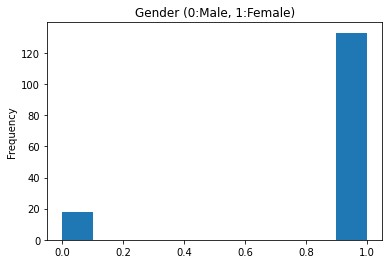

In [143]:
#Gender values distribution
dataset.Gen.apply(lambda x: 0 if x=='M' else 1).plot(kind='hist',title="Gender (0:Male, 1:Female)")

Note: Most of the students are female

<AxesSubplot:title={'center':'Major (0:Literature, 1:Translation)'}, ylabel='Frequency'>

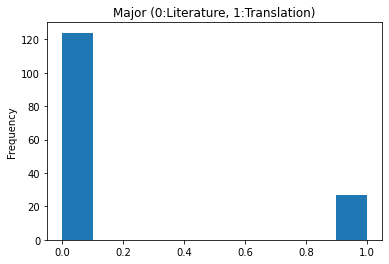

In [144]:
#Major values distribution
dataset.Major.apply(lambda x: 0 if x=='Literature' else 1).plot(kind='hist',title="Major (0:Literature, 1:Translation)")

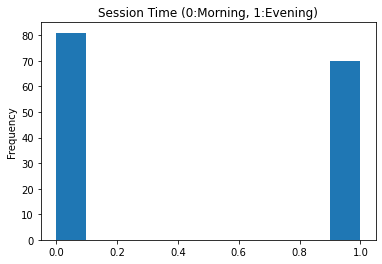

In [145]:
#Session values distribution
ax = dataset.Session.apply(lambda x: 0 if x=='Morning' else 1).plot(kind='hist',title="Session Time (0:Morning, 1:Evening)")

<AxesSubplot:title={'center':'Attendance'}, ylabel='Frequency'>

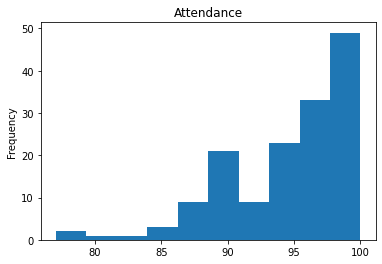

In [146]:
#Attendance values distribution
dataset.Attendance.plot(kind='hist',title="Attendance")

<AxesSubplot:title={'center':'Exam1Grade'}, ylabel='Frequency'>

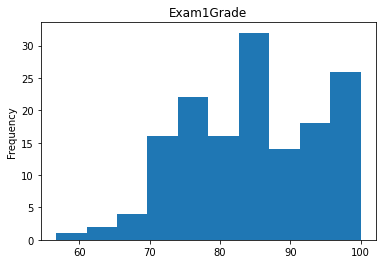

In [147]:
#Exam1Grade values distribution
dataset.Exam1Grade.plot(kind='hist',title="Exam1Grade")

<AxesSubplot:title={'center':'CGPA'}, ylabel='Frequency'>

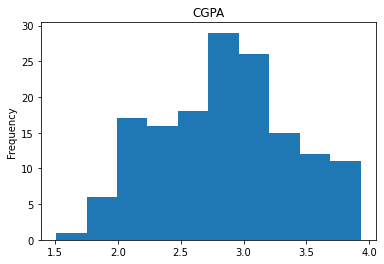

In [148]:
#CGPA values distribution
dataset.CGPA.plot(kind='hist',title="CGPA")

<AxesSubplot:title={'center':'PreReqGrades'}, ylabel='Frequency'>

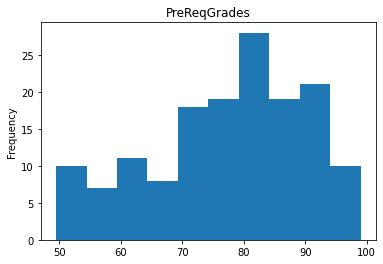

In [149]:
#PreReq_Grades values distribution
dataset.PreReq_Grades.plot(kind='hist',title="PreReqGrades")

<AxesSubplot:title={'center':'Class (0:Fail,1:Pass)'}, ylabel='Frequency'>

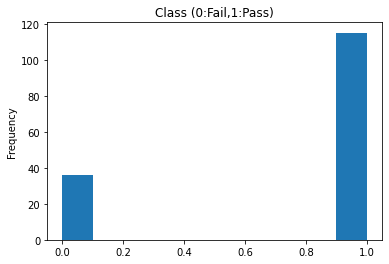

In [150]:
#Class values distribution
dataset.Class.apply(lambda x: 0 if x=='Low' else 1).plot(kind='hist',title="Class (0:Fail,1:Pass)")

/!\ We can see that we have a class imbalance in our data that we need to handle later /!\

### Transform Data

In [177]:
transformed_dataset = dataset
#Perform one-hot encoding on non numeric values:
encode_columns = [
    "Gen",
    "Session",
    "Major",
    "Sponsorship",
    "Dorm"
]
for c in encode_columns:
    transformed_dataset = transformed_dataset.join(pd.get_dummies(dataset[c],prefix=f"{c}_")).drop(c,axis=1)

#Scale percentages in range [0,1]
scale_percentages = [
    "Attendance",
    "Exam1Grade",
    "PreReq_Grades"
]
for c in divide_percentages:
    transformed_dataset[c] = transformed_dataset[c] / 100

#Scale CGPA in range [0,1]
transformed_dataset.CGPA = transformed_dataset.CGPA / 4

#Encode class :
transformed_dataset.Class = transformed_dataset.Class.apply(lambda x: 0 if x=='Low' else 1) #Student Passed (dataset class)
transformed_dataset.head()

,Attendance,Exam1Grade,CGPA,PreReq_Grades,Class,Gen__F,Gen__M,Session__Evening,Session__Morning,Major__Literature,Major__Translation,Sponsorship__N,Sponsorship__Y,Dorm__N,Dorm__Y
0,0.9687,0.900,0.8400,0.83,1,1,0,1,0,1,0,0,1,0,1
1,0.9375,0.767,0.6300,0.75,0,1,0,1,0,1,0,1,0,0,1
2,0.9583,0.933,0.8900,0.90,1,1,0,0,1,1,0,0,1,0,1
3,0.9687,0.967,0.6800,0.85,1,0,1,1,0,1,0,0,1,1,0
4,0.9687,1.000,0.7575,0.90,1,0,1,1,0,1,0,0,1,1,0


### Prepare Training and Test sets

In [178]:
#Get 80% of data for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(transformed_dataset.drop("Class",axis=1),transformed_dataset.Class,test_size=0.2,random_state=42)
y_train.value_counts()

1    92
0    28
Name: Class, dtype: int64

In [180]:
#Upscale minority class
df = X_train.join(y_train)
df_minor = df[df.Class==0]
df_major = df[df.Class==1]
majority_class_count = len(df_major)
minority_class_count = len(df_minor)
print(f"Class counts:\n > Minor class (Fail): {minority_class_count}\n > Major Class (Pass): {majority_class_count}\n > Total data: {minority_class_count+majority_class_count}")
df_minor_upscale = resample(df_minor, replace=True, n_samples=majority_class_count, random_state=42)
df = pd.concat([df_major,df_minor_upscale])
print(f"\nData count after upscaling: {len(df)}")
X_train = df.drop("Class",axis=1)
y_train = df.Class
print("\nFinal class counts:")
print(y_train.value_counts())

Class counts:
 > Minor class (Fail): 382
 > Major Class (Pass): 92
 > Total data: 474

Data count after upscaling: 184

Final class counts:
1    92
0    92
Name: Class, dtype: int64


### Train models

In [185]:
from sklearn.ensemble import RandomForestClassifier

models = [
    ['RandomForest',RandomForestClassifier(n_estimators=100, n_jobs=-1)]
    #More models to be implemented
]

for m in models:
    print(m[0])
    m[1].fit(X_train, y_train)
    print(f"Accuracy: {m[1].score(X_test, y_test)}")
    #More metrics to be implemented


RandomForest
Accuracy: 0.8387096774193549


### Work in progress...